# Sea Surface Temperature: Exploratory Analysis

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from matplotlib import pyplot as plt
from netCDF4 import Dataset

import cartopy
import cartopy.crs as ccrs

ABS_ZERO = -273.15

In [3]:
monthly_avg_ssts = xr.open_dataset('../SST_data/Historical/sst.mon.mean.nc', engine='netcdf4')
monthly_avg_ssts

<xarray.Dataset>
Dimensions:  (time: 499, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

### Monthly tropical mean

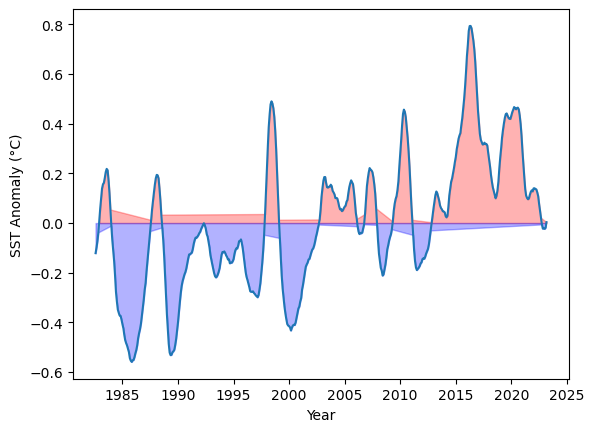

In [4]:
tropical_mean = monthly_avg_ssts['sst'].sel(lat=slice(-10,10)).mean(dim=['lat', 'lon'])
historical_tropical_mean = tropical_mean.mean(dim='time').values
rolling_tropical_mean = tropical_mean.rolling(time=12).mean().dropna(dim='time')
historical_tropical_mean_anomaly = rolling_tropical_mean - historical_tropical_mean
tropical_anomaly_df = historical_tropical_mean_anomaly.to_dataframe().reset_index()

def plot_anomaly(df, x_name, y_name, title, x_label, y_label):
    ax = sns.lineplot(data = df,y=y_name, x=x_name)
    line_obj = ax.lines[0]
    x1 = line_obj.get_xydata()[:,0]
    y1 = line_obj.get_xydata()[:,1]

    x1_pos = x1[y1 > 0]
    y1_pos = y1[y1 > 0]

    x1_neg = x1[y1 < 0]
    y1_neg = y1[y1 < 0]

    ax.fill_between(x1_pos,y1_pos, color="red", alpha=0.3)
    ax.fill_between(x1_neg,y1_neg, color="blue", alpha=0.3)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.show()
    fig = ax.get_figure()
    fig.savefig('./media/SST/anomaly/tropical_sst_anomaly.png')

plot_anomaly(
    tropical_anomaly_df, 
    y_name='sst', 
    x_name='time', 
    title='', 
    x_label='Year', 
    y_label='SST Anomaly (°C)')

In [5]:
monthly_avg_ssts

<xarray.Dataset>
Dimensions:  (time: 499, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [6]:

# IMPORT OUR MONTHLY MEAN SST DATA


MIN_LAT = -30
MAX_LAT = 30

MIN_LONG = 30
MAX_LONG = 240

NUM_DATAPOINTS_IN_YEAR = 12
monthly_avg_ssts = monthly_avg_ssts.sel(lon = slice(MIN_LONG, MAX_LONG), lat=slice(MIN_LAT, MAX_LAT))
# monthly_avg_ssts





### Where has warming been the worst?

In [7]:

# TODO: EXAMINE THE NAN's that appear here

with_deltas = monthly_avg_ssts.assign(delta = monthly_avg_ssts['sst'] - monthly_avg_ssts['sst'].mean('time'))
with_deltas


<xarray.Dataset>
Dimensions:  (time: 499, lat: 240, lon: 840)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 -29.88 -29.62 -29.38 -29.12 ... 29.38 29.62 29.88
  * lon      (lon) float32 30.12 30.38 30.62 30.88 ... 239.1 239.4 239.6 239.9
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... 16.14 16.01 15.91
    delta    (time, lat, lon) float32 nan nan nan nan ... -1.41 -1.542 -1.638
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

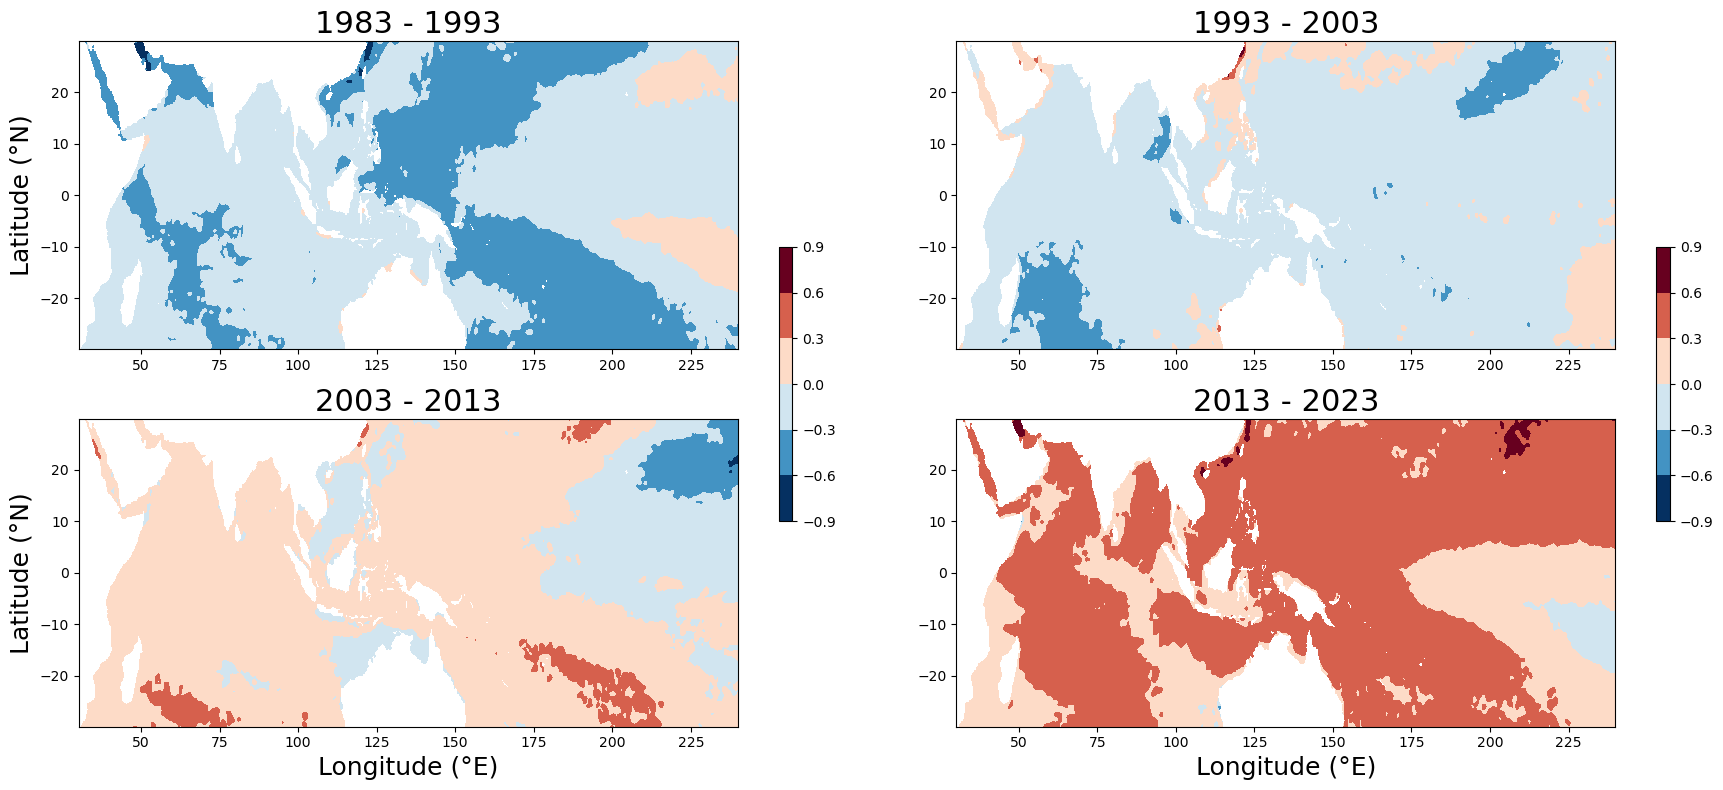

In [8]:
decade_start = 1983

fig, axs = plt.subplots(nrows= 2, ncols=2,figsize=(18,8))
row_num = 0
col_num = 0
while decade_start < 2023:
    ax = axs[row_num][col_num]
    decade_deltas = with_deltas.sel(
        time= (with_deltas.time.dt.year >= decade_start) 
        & (with_deltas.time.dt.year < decade_start + 10))
    
    decade_delta_mean = decade_deltas['delta'].mean('time')

    FIG_HEIGHT = 5
    ASPECT_RATIO =(MAX_LONG - MIN_LONG)/(MAX_LAT-MIN_LAT)

    # fig, axes = plt.subplots(figsize=(ASPECT_RATIO*FIG_HEIGHT, FIG_HEIGHT))
    mld = decade_delta_mean.plot.contourf(ax=ax, add_colorbar=False)

    ax.set_title(f"{str(decade_start)} - {str(decade_start + 10)}", fontsize= 22)

    if row_num == 1:
        ax.set_xlabel('Longitude (°E)', fontsize= 18)
    else:
        ax.set_xlabel('')
    if col_num == 0:
        ax.set_ylabel('Latitude (°N)', fontsize= 18)
    else:
        ax.set_ylabel('')
    
    # fig.suptitle(f"{str(decade_start)} - {str(decade_start + 10)} Mean SST", fontsize= 22)

    decade_start += 10
    
    col_num += 1
    if col_num == 2:
        col_num = 0
        row_num += 1

fig.tight_layout()
cbar = fig.colorbar(mld, ax=axs[:,0], shrink=0.4)
cbar = fig.colorbar(mld, ax=axs[:,1], shrink=0.4)

fig.savefig(f'./media/SST/decade_avgs/decade_avgs.png')



### Difference between basins

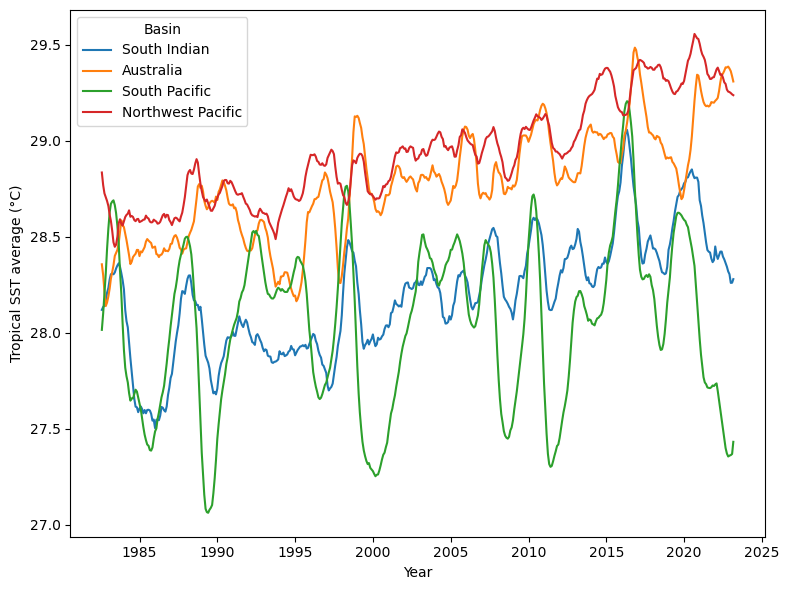

In [9]:
from utils.globals import SI_MIN, SI_MAX, SP_MIN, SP_MAX, AUS_MIN, AUS_MAX, NWP_MIN, NWP_MAX

## only select tropical here
southern_tropical = monthly_avg_ssts.sel(lat = slice(-10,0))
northern_tropical = monthly_avg_ssts.sel(lat = slice(0,10))

si_tropical = southern_tropical['sst'].sel(lon = slice(SI_MIN, SI_MAX)).mean(dim=['lat', 'lon']).rolling(time=12).mean().dropna(dim='time')
aus_tropical = southern_tropical['sst'].sel(lon = slice(AUS_MIN, AUS_MAX)).mean(dim=['lat', 'lon']).rolling(time=12).mean().dropna(dim='time')
sp_tropical = southern_tropical['sst'].sel(lon = slice(SP_MIN, SP_MAX)).mean(dim=['lat', 'lon']).rolling(time=12).mean().dropna(dim='time')
nwp_tropical = northern_tropical['sst'].sel(lon = slice(NWP_MIN, NWP_MAX)).mean(dim=['lat', 'lon']).rolling(time=12).mean().dropna(dim='time')



# find contribution to tropical sst
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(si_tropical.to_series(), ax=ax,label='South Indian')
sns.lineplot(aus_tropical.to_series(), ax=ax,label='Australia')
sns.lineplot(sp_tropical.to_series(), ax=ax,label='South Pacific')
sns.lineplot(nwp_tropical.to_series(), ax=ax,label='Northwest Pacific')
ax.legend(title='Basin')
ax.set_ylabel('Tropical SST average (°C)')
ax.set_xlabel('Year')
fig.tight_layout()
plt.show()
fig.savefig(f'./media/SST/region_trends.png')


## TODO: trends in SSTs in cyclone-forming months and locations?

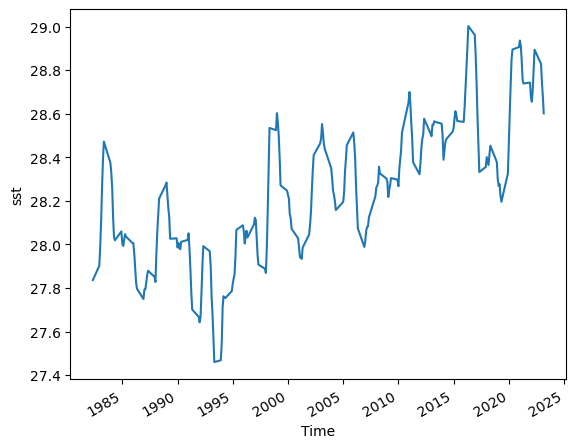

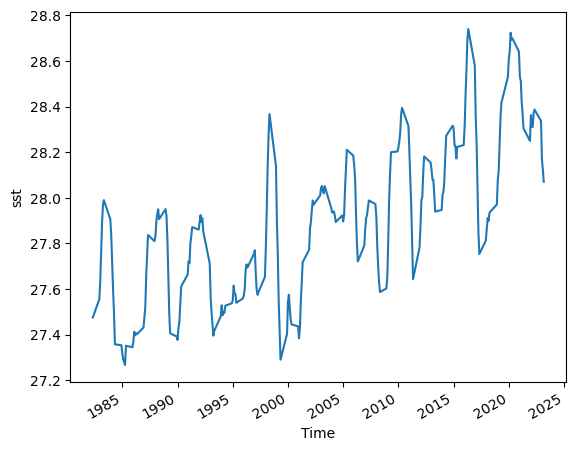

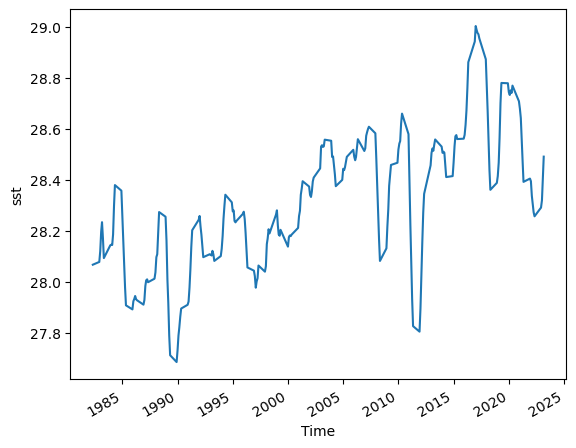

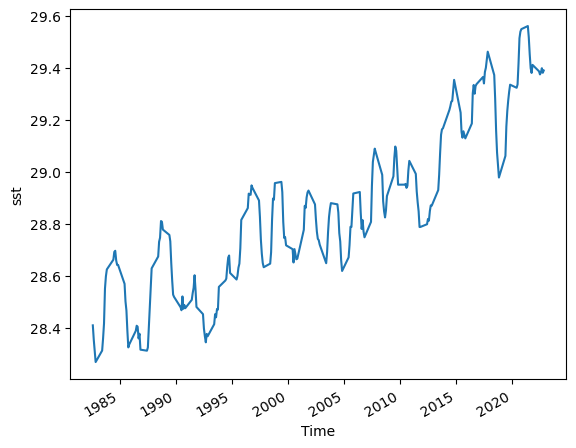

In [10]:
northern_cyclone_months = [6, 7,8,9,10,11]
southern_cyclone_months = [12,1,2,3,4, 5]

southern_cyclone_locs = monthly_avg_ssts.sel(lat = slice(-20,-10))
northern_cyclone_locs = monthly_avg_ssts.sel(lat = slice(10, 20))

aus_cyclone_locs = southern_cyclone_locs['sst'].sel(lon = slice(AUS_MIN, AUS_MAX), time=(southern_cyclone_locs.time.dt.month.isin(southern_cyclone_months)))
si_cyclone_locs = southern_cyclone_locs['sst'].sel(lon = slice(SI_MIN, SI_MAX), time=(southern_cyclone_locs.time.dt.month.isin(southern_cyclone_months)))
sp_cyclone_locs = southern_cyclone_locs['sst'].sel(lon = slice(SP_MIN, SP_MAX), time=(southern_cyclone_locs.time.dt.month.isin(southern_cyclone_months)))
nwp_cyclone_locs = northern_cyclone_locs['sst'].sel(lon = slice(NWP_MIN, NWP_MAX), time=(northern_cyclone_locs.time.dt.month.isin(northern_cyclone_months)))

nwp_cyclone_locs.to_dataframe().reset_index()

for xarray in [aus_cyclone_locs, si_cyclone_locs, sp_cyclone_locs, nwp_cyclone_locs]:
    xarray.mean(dim=['lat','lon']).rolling(time=6).mean().dropna(dim='time').plot.line()
    plt.show()



